<a href="https://colab.research.google.com/github/descartesmbogning/Deciphering_Bacteriophage_Revolution/blob/main/1_patent_analysis_trend2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
from functools import reduce
import seaborn as sns
import missingno as msno
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.stats import norm


In [ ]:
# Set the figure size - handy for larger output
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

In [ ]:
from scipy import stats #the only import you actually need for this
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [ ]:
# function that tests distribution then picks test accordingly
def test_sig(x, y):
    if stats.shapiro(x).pvalue >= 0.05 and stats.shapiro(y).pvalue >= 0.05: #if they are normally distriuted
        print("t-test")
        return stats.ttest_ind(x,y)
    else:
        print("mann-whitney")
        return stats.mannwhitneyu(x, y)

## import data

In [ ]:
#Import data
data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')
# Convert 'Publication Year' to integers
data['Publication Year'] = data['Publication Year'].astype(int)

data.head()

,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,...,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
0,3344,ES,A1,ES 208289 A1,076-302-161-945-12X,16/05/1953,1953,ES 208289 A,16/03/1953,DE 208289T A,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,EXPIRED
1,4287,US,A,US 2638436 A,144-374-709-185-304,12/05/1953,1953,US 9862749 A,11/06/1949,US 9862749 A,...,0,C12N1/20;;C12N1/36;;C12P19/42;;C12P19/54;;Y10S...,C12N1/20;;C12N1/36;;C12P19/42;;C12P19/54,NaN,0,0,NaN,NaN,NaN,EXPIRED
2,6339,GB,A,GB 695171 A,054-072-674-443-759,05/08/1953,1953,GB 2140051 A,11/09/1951,US 695171X A,...,0,C12R2001/66;;C12N1/14;;C12N1/145,NaN,C2C CBA;;C2C CME;;C2C C1300;;C2C C1300;;C2C C2...,0,0,NaN,NaN,NaN,EXPIRED
3,4207,ES,A1,ES 222613 A1,141-974-976-614-046,01/01/1956,1956,ES 222613 A,24/06/1955,US 47624154 A,...,0,C12P19/54;;Y10S435/897;;C12N1/205;;C12P19/54;;...,NaN,NaN,0,0,NaN,NaN,NaN,EXPIRED
4,632,GB,A,GB 771653 A,133-899-733-964-634,03/04/1957,1957,GB 2497655 A,31/08/1955,GB 2497655 A,...,0,A61K35/76;;C12N7/00;;C12N2795/00032;;C12N2795/...,A61K35/76;;C12N7/00,A5B B721 L;;A5B B722 L;;A5B ...,0,0,NaN,NaN,NaN,EXPIRED


In [ ]:
# Check the number of patents
num_patents = data.shape[0]
print(f"Number of Patents: {num_patents}")


Number of Patents: 6427


In [ ]:
# Filter data from 1973
data_50 = data[data['Publication Year'] >= 1973]

# Display filtered data
data_50.head()


,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,...,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
27,528,GB,A,GB 1303802 A,138-286-275-138-297,24/01/1973,1973,GB 1303802D A,16/01/1969,GB 269769 A,...,0,C12Q1/70;;G01N33/532;;G01N33/542;;Y10S436/817;...,A61K35/66;;C12Q1/70;;G01N33/532;;G01N33/53;;G0...,NaN,0,0,NaN,NaN,NaN,EXPIRED
28,1425,GB,A,GB 1356503 A,138-798-089-565-745,12/06/1974,1974,GB 2113872 A,05/05/1972,US 14102671 A,...,0,G01N33/56938;;Y10S436/811;;Y10S436/802;;Y10S43...,G01N33/569,G1B B11E B1X1;;G1B B11M B1X1...,0,0,NaN,NaN,NaN,EXPIRED
29,2524,US,A,US 3819482 A,153-074-527-302-225,25/06/1974,1974,US 25125772 A,08/05/1972,US 25125772 A,...,0,C07H21/00;;C12N7/00;;C12N2795/14251;;C12P19/34...,C07H21/00;;C12N7/00;;C12P19/34,195-028 N,1,1,044-768-716-223-256,10.1073/pnas.58.5.2102;;pmc223911;;4295588,"Field et al., National Academy of Science Proc...",EXPIRED
30,3948,FR,A1,FR 2186235 A1,168-969-896-505-628,11/01/1974,1974,FR 7216033 A,05/05/1972,FR 7216033 A,...,0,A61K35/74;;C12N1/205;;C12P1/04;;C12R2001/01,A61K35/74;;C12P1/04,NaN,0,0,NaN,NaN,NaN,EXPIRED
31,4649,ES,A1,ES 392830 A1,196-308-109-446-727,16/12/1974,1974,ES 392830 A,02/06/1971,CH 631971 A,...,0,A61K39/0275;;A61K39/0275;;Y02A50/30,A61K39/00;;A61K39/02;;A61K39/112,NaN,0,0,NaN,NaN,NaN,EXPIRED


In [ ]:
# Check the number of patents
num_patents_50 = data_50.shape[0]
print(f"Number of Patents last 50 years: {num_patents_50}")


Number of Patents last 50 years: 6400


# Publications trends

In [ ]:
data_trend = data_50['Publication Year'].value_counts().reset_index().sort_values('index')
# Calculate the inverse cumulative proportion
#data_trend['Inverse Cumulative Proportion'] = data_trend['Publication Year'].iloc[::-1].cumsum() / data_trend['Publication Year'].sum()

data_trend

,index,Publication Year
50,1973,1
47,1974,4
49,1975,1
48,1976,2
46,1977,5
44,1978,13
43,1979,14
45,1980,5
42,1981,17
41,1982,20


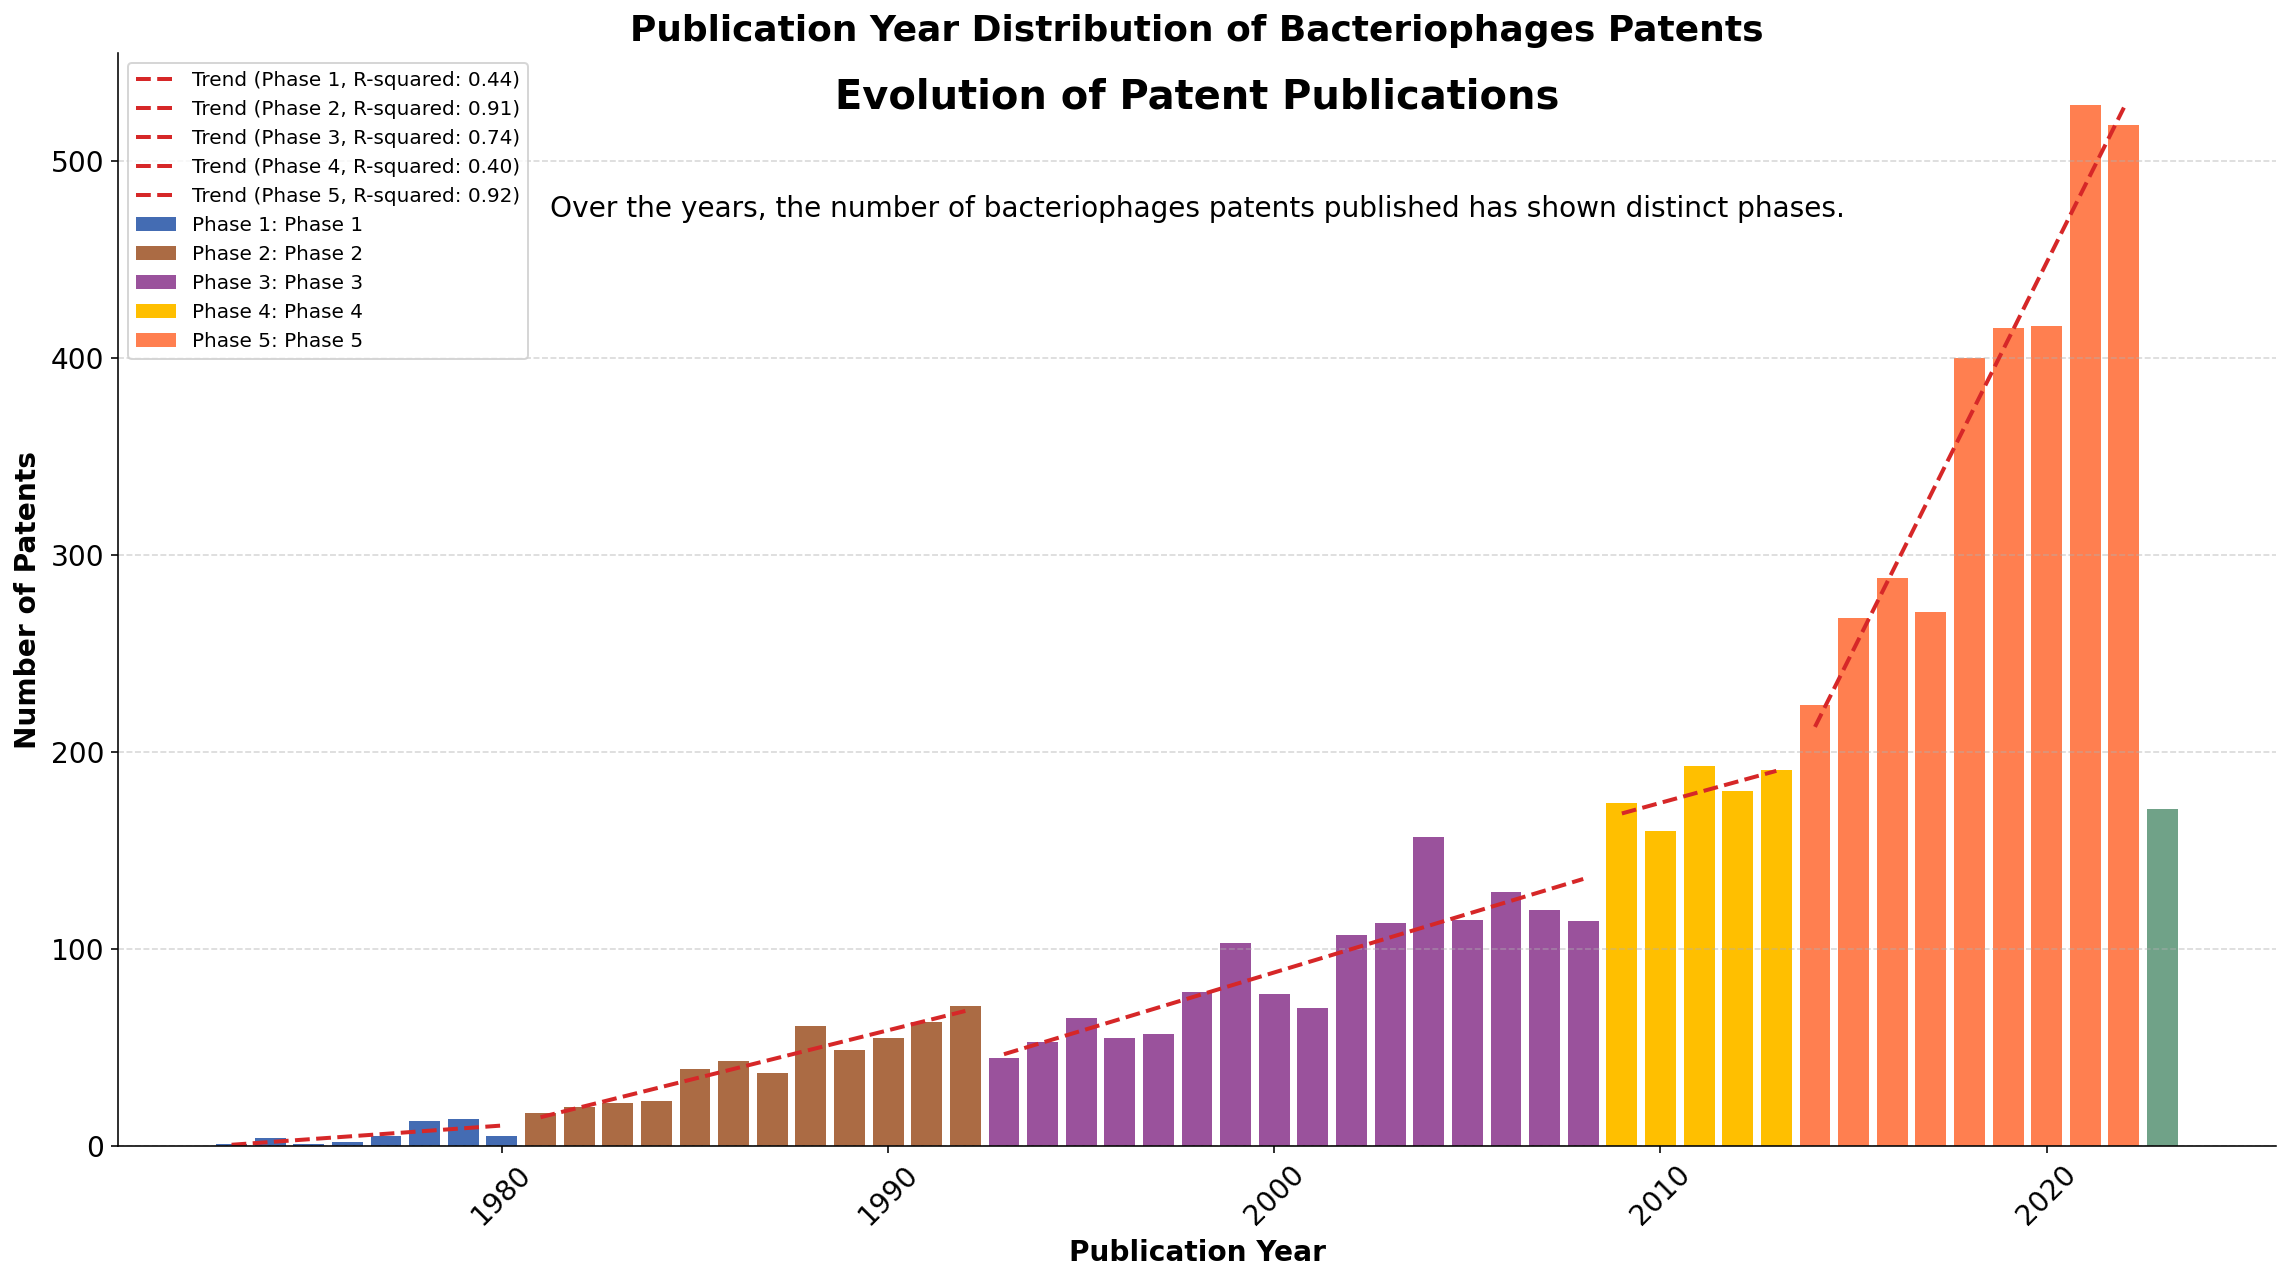

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Data
data = {
    'Publication Year': [1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
                         1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
                         2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                         2018, 2019, 2020, 2021, 2022, 2023],
    'Count': [1, 4, 1, 2, 5, 13, 14, 5, 17, 20, 22, 23, 39, 43, 37, 61, 49, 55, 63, 71, 45, 53, 65, 55, 57, 78,
              103, 77, 70, 107, 113, 157, 115, 129, 120, 114, 174, 160, 193, 180, 191, 224, 268, 288, 271, 400,
              415, 416, 528, 518, 171]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Create a figure and axes with enlarged size
fig, ax = plt.subplots(figsize=(16, 9))

# Set colors
bar_color = '#70a288'  # Green color for bars
trendline_color = '#d62728'  # Red color for trendline
phase_colors = ['#446cb3', '#ab6b44', '#9a529c', '#ffbf00', '#ff7f50']  # Blue, Orange, Purple, Yellow, Coral colors for phases

# Create the bar plot with custom color
bars = ax.bar(df['Publication Year'], df['Count'], color=bar_color)

# Define the phases of the trend
phases = [
    {'start': 1973, 'end': 1980, 'label': 'Phase 1'},
    {'start': 1981, 'end': 1992, 'label': 'Phase 2'},
    {'start': 1993, 'end': 2008, 'label': 'Phase 3'},
    {'start': 2009, 'end': 2013, 'label': 'Phase 4'},
    {'start': 2014, 'end': 2022, 'label': 'Phase 5'}
]

# Calculate the trendline and R-squared value for each phase
for i, phase in enumerate(phases):
    phase_data = df[(df['Publication Year'] >= phase['start']) & (df['Publication Year'] <= phase['end'])]
    slope, intercept, r_value, p_value, std_err = linregress(phase_data['Publication Year'], phase_data['Count'])
    phase_line = slope * phase_data['Publication Year'] + intercept
    r_squared = r_value ** 2

    # Highlight the phase with a different color
    ax.bar(
        phase_data['Publication Year'],
        phase_data['Count'],
        color=phase_colors[i],
        label=f'Phase {i + 1}: {phase["label"]}',
    )

    # Plot the trendline associated with the phase
    ax.plot(
        phase_data['Publication Year'],
        phase_line,
        color=trendline_color,
        linestyle='--',
        linewidth=2,
        label=f'Trend (Phase {i + 1}, R-squared: {r_squared:.2f})',
    )

# Customize the plot
ax.set_xlabel('Publication Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patents', fontsize=14, fontweight='bold')
ax.set_title('Publication Year Distribution of Bacteriophages Patents', fontsize=18, fontweight='bold')

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Set font size and rotation angle for tick labels
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)

# Add a narrative description
ax.text(
    0.5,
    0.95,
    'Evolution of Patent Publications',
    transform=ax.transAxes,
    ha='center',
    fontsize=20,
    fontweight='bold',
)
ax.text(
    0.5,
    0.85,
    'Over the years, the number of bacteriophages patents published has shown distinct phases.',
    transform=ax.transAxes,
    ha='center',
    fontsize=14,
)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend for the different phases and trends
ax.legend(loc='upper left', fontsize=10)

# Save the plot at 300 dpi
plt.tight_layout()
plt.savefig('D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/figure/patent_publication_year_plot.png', dpi=300)

# Show the plot (optional)
plt.show()


# Applicants

In [ ]:
#Import applicants_data
applicants_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','Applicants','Cited by Patent Count']]
# Convert 'Publication Year' to integers
applicants_data['Publication Year'] = applicants_data['Publication Year'].astype(int)

applicants_data = applicants_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])
applicants_data

,,,Applicants
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,METALLGESELLSCHAFT AG
144-374-709-185-304,1953,1,OLIN MATHIESON
054-072-674-443-759,1953,1,UPJOHN CO
141-974-976-614-046,1956,0,SCHENLEY IND INC
133-899-733-964-634,1957,3,MEDICO BIOLOG LAB LTD
...,...,...,...
014-435-173-743-592,2023,0,UNIV ROCKEFELLER
197-343-525-039-178,2023,0,HANGZHOU FEITAI MEMBRANE TECH CO LTD
074-411-502-978-49X,2023,0,IAC IN NAT UNIV CHUNGNAM


In [ ]:
import pandas as pd

# Your DataFrame is named applicants_data
applicants_list = applicants_data['Applicants'].str.split(';;').explode().str.strip()

# Count the unique applicants names
unique_applicants_count = applicants_list.nunique()

print('The number of unique applicants is:', unique_applicants_count)

#
applicants_list2 = applicants_list.to_frame().reset_index()

# and sum citations within each group
grouped = applicants_list2.groupby(['Applicants']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/applicants_data['Applicants'].count()*100

# Rename columns
grouped.columns = ['Applicants', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/applicants_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/applicants_count_citation.csv')

grouped.head(50)

The number of unique applicants is: 5125


,Applicants,count,citation,%
0,(주)일신이디아이,1,0,0.015721
1,13 8 INC,1,0,0.015721
2,2ND AF HOSP GUANGZHOU MED UNIV,1,2,0.015721
3,3M INNOVATIVE PROPERTIES CO,3,54,0.047162
4,48HOUR DISCOVERY INC,1,0,0.015721
5,4BASEBIO SL,1,0,0.015721
6,4D PHARMA LEON S L U,1,0,0.015721
7,A & R THERAPEUTICS CO LTD,1,6,0.015721
8,AAHLEN JOAKIM,1,3,0.015721
9,AARON DIAMOND AIDS RES CT,1,0,0.015721


In [ ]:
# Reset the index to make 'Publication Year' a regular column
applicants_list2 = applicants_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
applicants_list2['Year Group'] = pd.cut(applicants_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = applicants_list2.groupby(['Year Group','Applicants']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Applicants', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Applicants,Publication Count,Total Citations
725,"(1953, 1958]",COMMONWEATH SCIENT AND IND RES,1,3
1130,"(1953, 1958]",FISONS MILK PRODUCTS LTD,1,3
2531,"(1953, 1958]",MEDICO BIOLOG LAB LTD,1,3
3440,"(1953, 1958]",SCHENLEY IND INC,1,0
5485,"(1958, 1963]",BIOGENA,1,9
...,...,...,...,...
71722,"(2018, 2023]",ZIBO XUNZHIFANG TECH DEVELOPMENT CO LTD,1,0
71726,"(2018, 2023]",ZINAMIRA AG,1,0
71735,"(2018, 2023]",ZUMUTOR BIOLOGICS INC,2,2
71742,"(2018, 2023]",ZYMERGEN INC,2,1


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Applicants', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/applicants_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/applicants_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count  \
Year Group                                              (1953, 1958]   
Applicants                                                             
(주)일신이디아이                                                        NaN   
13 8 INC                                                         NaN   
2ND AF HOSP GUANGZHOU MED UNIV                                   NaN   
3M INNOVATIVE PROPERTIES CO                                      NaN   
48HOUR DISCOVERY INC                                             NaN   
...                                                              ...   
БЕРІНГЕР МАННХАЙМ ГМБХ                                           NaN   
“UKRAINIAN MEDICAL STOMATOLOGICAL ACADEMY” HIGH...               NaN   
서울대학교산학협력단                                                       NaN   
이상훈                                                              NaN   
주식회사 비엠씨                                                         NaN   

                                                                              \
Year Group                                         (1958, 1963] (1963, 1968]   
Applicants                                                                     
(주)일신이디아이                                                   NaN          NaN   
13 8 INC                                                    NaN          NaN   
2ND AF HOSP GUANGZHOU MED UNIV                              NaN          NaN   
3M INNOVATIVE PROPERTIES CO                                 NaN          NaN   
48HOUR DISCOVERY INC                                        NaN          NaN   
...                                                         ...          ...   
БЕРІНГЕР МАННХАЙМ ГМБХ                                      NaN          NaN   
“UKRAINIAN MEDICAL STOMATOLOGICAL ACADEMY” HIGH...          NaN          NaN   
서울대학교산학협력단                                                  NaN          NaN   
이상훈                                                         NaN          NaN   
주식회사 비엠씨                                                    NaN          NaN   

                                                                              \
Year Group                                         (1968, 1973] (1973, 1978]   
Applicants                                                                     
(주)일신이디아이                                                   NaN          NaN   
13 8 INC                                                    NaN          NaN   
2ND AF HOSP GUANGZHOU MED UNIV                              NaN          NaN   
3M INNOVATIVE PROPERTIES CO                                 NaN          NaN   
48HOUR DISCOVERY INC                                        NaN          NaN   
...                                                         ...          ...   
БЕРІНГЕР МАННХАЙМ ГМБХ                                      NaN          NaN   
“UKRAINIAN MEDICAL STOMATOLOGICAL ACADEMY” HIGH...          NaN          NaN   
서울대학교산학협력단                                                  NaN          NaN   
이상훈                                                         NaN          NaN   
주식회사 비엠씨                                                    NaN          NaN   

                                                                              \
Year Group                                         (1978, 1983] (1983, 1988]   
Applicants                                                                     
(주)일신이디아이                                                   NaN          NaN   
13 8 INC                                                    NaN          NaN   
2ND AF HOSP GUANGZHOU MED UNIV                              NaN          NaN   
3M INNOVATIVE PROPERTIES CO                                 NaN          NaN   
48HOUR DISCOVERY INC                                        NaN          NaN   
...                                                         ...          ...   
БЕРІНГЕР МАННХАЙМ ГМБХ                                      NaN          NaN   


# Inventors

In [ ]:
#Import inventors_data
inventors_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','Inventors','Cited by Patent Count']]
# Convert 'Publication Year' to integers
inventors_data['Publication Year'] = inventors_data['Publication Year'].astype(int)

inventors_data = inventors_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])

inventors_data

,,,Inventors
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,NaN
144-374-709-185-304,1953,1,DAVID PERLMAN;;LANGLYKKE ASGER F
054-072-674-443-759,1953,1,NaN
141-974-976-614-046,1956,0,NaN
133-899-733-964-634,1957,3,PECOU HENRI JEAN
...,...,...,...
014-435-173-743-592,2023,0,MEESKE ALEXANDER;;MARRAFFINI LUCIANO
197-343-525-039-178,2023,0,XIE XIAOFENG;;XIANG LICHAO
074-411-502-978-49X,2023,0,SHIN HYUN JIN;;DE ZOYSA MAHANAMA;;NIKAPITIYA C...


In [ ]:
import pandas as pd

# Your DataFrame is named inventors_data
inventors_list = inventors_data['Inventors'].str.split(';;').explode().str.strip()

# Count the unique inventors names
unique_inventors_count = inventors_list.nunique()

print('The number of unique inventors is:', unique_inventors_count)

#
inventors_list2 = inventors_list.to_frame().reset_index()

# and sum citations within each group
grouped = inventors_list2.groupby(['Inventors']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/inventors_data['Inventors'].count()*100

# Rename columns
grouped.columns = ['Inventors', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/inventors_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/inventors_count_citation.csv')

grouped.head(50)

The number of unique inventors is: 15066


,Inventors,count,citation,%
0,A MINA,1,4,0.015845
1,A P NETHRAVATHI,1,0,0.015845
2,AAGE LOESET GEIR,1,2,0.015845
3,AAHLEN JOAKIM,1,3,0.015845
4,ABAEV IGOR V,3,1,0.047536
5,ABAEV IGOR VALENTINOVICH,1,1,0.015845
6,ABD-JAMIL JURAINA,1,0,0.015845
7,ABDELHAKIM KHARRAT,1,0,0.015845
8,ABDRAKHMANOVA RADMILA OKHASOVNA,1,0,0.015845
9,ABDULAMIR AHMED SAHIB,2,1,0.031691


In [ ]:
# Reset the index to make 'Publication Year' a regular column
inventors_list2 = inventors_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
inventors_list2['Year Group'] = pd.cut(inventors_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = inventors_list2.groupby(['Year Group','Inventors']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Inventors', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Inventors,Publication Count,Total Citations
9081,"(1953, 1958]",PECOU HENRI JEAN,1,3
9664,"(1953, 1958]",REITER BRUNO,1,3
10183,"(1953, 1958]",SCOTT MAURICE LIDSTONE,1,3
17043,"(1958, 1963]",DAVIES AYRON GWYNN,1,0
17333,"(1958, 1963]",DOOLEY ELMO S,1,3
...,...,...,...,...
210917,"(2018, 2023]",안혁태,1,0
210919,"(2018, 2023]",유상열,1,0
210921,"(2018, 2023]",이유나,1,0
210922,"(2018, 2023]",조도형,1,0


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Inventors', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/inventors_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/inventors_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group            (1953, 1958] (1958, 1963] (1963, 1968] (1968, 1973]   
Inventors                                                                   
A MINA                         NaN          NaN          NaN          NaN   
A P NETHRAVATHI                NaN          NaN          NaN          NaN   
AAGE LOESET GEIR               NaN          NaN          NaN          NaN   
AAHLEN JOAKIM                  NaN          NaN          NaN          NaN   
ABAEV IGOR V                   NaN          NaN          NaN          NaN   
...                            ...          ...          ...          ...   
유상열                            NaN          NaN          NaN          NaN   
이상훈                            NaN          NaN          NaN          NaN   
이유나                            NaN          NaN          NaN          NaN   
조도형                            NaN          NaN          NaN          NaN   
차여연                            NaN          NaN          NaN          NaN   

                                                                      \
Year Group       (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993]   
Inventors                                                              
A MINA                    NaN          NaN          NaN          NaN   
A P NETHRAVATHI           NaN          NaN          NaN          NaN   
AAGE LOESET GEIR          NaN          NaN          NaN          NaN   
AAHLEN JOAKIM             NaN          NaN          NaN          NaN   
ABAEV IGOR V              NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
유상열                       NaN          NaN          NaN          NaN   
이상훈                       NaN          NaN          NaN          NaN   
이유나                       NaN          NaN          NaN          NaN   
조도형                       NaN          NaN          NaN          NaN   
차여연                       NaN          NaN          NaN          NaN   

                                            ... Total Citations               \
Year Group       (1993, 1998] (1998, 2003]  ...    (1973, 1978] (1978, 1983]   
Inventors                                   ...                                
A MINA                    NaN          NaN  ...             NaN          NaN   
A P NETHRAVATHI           NaN          NaN  ...             NaN          NaN   
AAGE LOESET GEIR          NaN          NaN  ...             NaN          NaN   
AAHLEN JOAKIM             NaN          1.0  ...             NaN          NaN   
ABAEV IGOR V              NaN          NaN  ...             NaN          NaN   
...                       ...          ...  ...             ...          ...   
유상열                       NaN          NaN  ...             NaN          NaN   
이상훈                       NaN          NaN  ...             NaN          NaN   
이유나                       NaN          NaN  ...             NaN          NaN   
조도형                       NaN          NaN  ...             NaN          NaN   
차여연                       NaN          NaN  ...             NaN          NaN   

                                                                      \
Year Group       (1983, 1988] (1988, 1993] (1993, 1998] (1998, 2003]   
Inventors                                                              
A MINA                    NaN          NaN          NaN          NaN   
A P NETHRAVATHI           NaN          NaN          NaN          NaN   
AAGE LOESET GEIR          NaN          NaN          NaN          NaN   
AAHLEN JOAKIM             NaN          NaN          NaN          3.0   
ABAEV IGOR V              NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
유상열                       NaN          NaN          NaN          NaN   
이상훈                       NaN          NaN          NaN          NaN   
이유나             

# Jurisdiction

In [ ]:
#Import jurisdiction_data
jurisdiction_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','Jurisdiction','Cited by Patent Count']]
# Convert 'Publication Year' to integers
jurisdiction_data['Publication Year'] = jurisdiction_data['Publication Year'].astype(int)

jurisdiction_data = jurisdiction_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])
jurisdiction_data

,,,Jurisdiction
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,ES
144-374-709-185-304,1953,1,US
054-072-674-443-759,1953,1,GB
141-974-976-614-046,1956,0,ES
133-899-733-964-634,1957,3,GB
...,...,...,...
014-435-173-743-592,2023,0,EP
197-343-525-039-178,2023,0,CN
074-411-502-978-49X,2023,0,KR


In [ ]:
import pandas as pd

# Your DataFrame is named jurisdiction_data
jurisdiction_list = jurisdiction_data['Jurisdiction'].str.split(';;').explode().str.strip()

# Count the unique jurisdiction names
unique_jurisdiction_count = jurisdiction_list.nunique()

print('The number of unique jurisdiction is:', unique_jurisdiction_count)

#
jurisdiction_list2 = jurisdiction_list.to_frame().reset_index()

# and sum citations within each group
grouped = jurisdiction_list2.groupby(['Jurisdiction']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/jurisdiction_data['Jurisdiction'].count()*100

# Rename columns
grouped.columns = ['Jurisdiction', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/jurisdiction_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/jurisdiction_count_citation.csv')

grouped.head(50)

The number of unique jurisdiction is: 47


,Jurisdiction,count,citation,%
0,AP,1,0,0.015559
1,AT,1,0,0.015559
2,AU,89,10,1.384783
3,BG,6,0,0.093356
4,CA,144,27,2.240548
5,CH,2,0,0.031119
6,CN,2492,4924,38.773923
7,CS,1,3,0.015559
8,CZ,9,1,0.140034
9,DE,42,121,0.653493


In [ ]:
# Reset the index to make 'Publication Year' a regular column
jurisdiction_list2 = jurisdiction_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
jurisdiction_list2['Year Group'] = pd.cut(jurisdiction_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = jurisdiction_list2.groupby(['Year Group','Jurisdiction']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Jurisdiction', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Jurisdiction,Publication Count,Total Citations
13,"(1953, 1958]",ES,1,0
15,"(1953, 1958]",GB,3,9
62,"(1958, 1963]",GB,4,9
91,"(1958, 1963]",US,2,15
109,"(1963, 1968]",GB,4,11
...,...,...,...,...
650,"(2018, 2023]",SK,1,0
653,"(2018, 2023]",TW,8,0
655,"(2018, 2023]",US,240,145
656,"(2018, 2023]",WO,270,283


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Jurisdiction', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/jurisdiction_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/jurisdiction_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group        (1953, 1958] (1958, 1963] (1963, 1968] (1968, 1973]   
Jurisdiction                                                            
AP                         NaN          NaN          NaN          NaN   
AT                         NaN          NaN          NaN          NaN   
AU                         NaN          NaN          NaN          NaN   
BG                         NaN          NaN          NaN          NaN   
CA                         NaN          NaN          NaN          NaN   
CH                         NaN          NaN          NaN          2.0   
CN                         NaN          NaN          NaN          NaN   
CS                         NaN          NaN          NaN          NaN   
CZ                         NaN          NaN          NaN          NaN   
DE                         NaN          NaN          NaN          NaN   
DK                         NaN          NaN          NaN          NaN   
EA                         NaN          NaN          NaN          NaN   
EP                         NaN          NaN          NaN          NaN   
ES                         1.0          NaN          NaN          1.0   
FR                         NaN          NaN          NaN          NaN   
GB                         3.0          4.0          4.0          7.0   
GE                         NaN          NaN          NaN          NaN   
GR                         NaN          NaN          NaN          NaN   
HU                         NaN          NaN          NaN          NaN   
IE                         NaN          NaN          NaN          NaN   
IL                         NaN          NaN          NaN          NaN   
IN                         NaN          NaN          NaN          NaN   
IT                         NaN          NaN          NaN          NaN   
JO                         NaN          NaN          NaN          NaN   
JP                         NaN          NaN          NaN          NaN   
KR                         NaN          NaN          NaN          NaN   
LV                         NaN          NaN          NaN          NaN   
MX                         NaN          NaN          NaN          NaN   
MY                         NaN          NaN          NaN          NaN   
NL                         NaN          NaN          NaN          NaN   
NZ                         NaN          NaN          NaN          NaN   
PH                         NaN          NaN          NaN          NaN   
PL                         NaN          NaN          NaN          NaN   
PT                         NaN          NaN          NaN          NaN   
RO                         NaN          NaN          NaN          NaN   
RU                         NaN          NaN          NaN          NaN   
SE                         NaN          NaN          NaN          NaN   
SG                         NaN          NaN          NaN          NaN   
SI                         NaN          NaN          NaN          NaN   
SK                         NaN          NaN          NaN          NaN   
SU                         NaN          NaN          NaN          NaN   
TN                         NaN          NaN          NaN          NaN   
TW                         NaN          NaN          NaN          NaN   
UA                         NaN          NaN          NaN          NaN   
US                         NaN          2.0          1.0          NaN   
WO                         NaN          NaN          NaN          NaN   
ZA                         NaN          NaN          NaN          NaN   

                                                                               \
Year Group   (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993] (1993, 1998]   
Jurisdiction                                                                    
AP                    NaN          NaN          NaN          NaN          NaN   
AT                    NaN          NaN

# Kind

In [ ]:
#Import kind_data
kind_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','Kind','Cited by Patent Count']]
# Convert 'Publication Year' to integers
kind_data['Publication Year'] = kind_data['Publication Year'].astype(int)

kind_data = kind_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])
kind_data

,,,Kind
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,A1
144-374-709-185-304,1953,1,A
054-072-674-443-759,1953,1,A
141-974-976-614-046,1956,0,A1
133-899-733-964-634,1957,3,A
...,...,...,...
014-435-173-743-592,2023,0,A2
197-343-525-039-178,2023,0,A
074-411-502-978-49X,2023,0,A


In [ ]:
import pandas as pd

# Your DataFrame is named kind_data
kind_list = kind_data['Kind'].str.split(';;').explode().str.strip()

# Count the unique kind names
unique_kind_count = kind_list.nunique()

print('The number of unique kind is:', unique_kind_count)

#
kind_list2 = kind_list.to_frame().reset_index()

# and sum citations within each group
grouped = kind_list2.groupby(['Kind']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/kind_data['Kind'].count()*100

# Rename columns
grouped.columns = ['Kind', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/kind_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/kind_count_citation.csv')

grouped.head(50)

The number of unique kind is: 23


,Kind,count,citation,%
0,A,3332,15177,51.843784
1,A0,7,1,0.108916
2,A1,1411,8253,21.954255
3,A2,145,838,2.256107
4,A3,167,3,2.598413
5,A4,12,1,0.186712
6,A6,4,0,0.062237
7,A8,10,0,0.155594
8,A9,13,31,0.202272
9,B,82,10,1.275867


In [ ]:
# Reset the index to make 'Publication Year' a regular column
kind_list2 = kind_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
kind_list2['Year Group'] = pd.cut(kind_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = kind_list2.groupby(['Year Group','Kind']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Kind', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Kind,Publication Count,Total Citations
0,"(1953, 1958]",A,3,9
2,"(1953, 1958]",A1,1,0
23,"(1958, 1963]",A,6,24
46,"(1963, 1968]",A,5,17
69,"(1968, 1973]",A,9,2
...,...,...,...,...
314,"(2018, 2023]",C2,6,0
316,"(2018, 2023]",D0,3,0
318,"(2018, 2023]",U,135,16
319,"(2018, 2023]",U1,3,1


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Kind', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/kind_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/kind_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group      (1953, 1958] (1958, 1963] (1963, 1968] (1968, 1973]   
Kind                                                                  
A                        3.0          6.0          5.0          9.0   
A0                       NaN          NaN          NaN          NaN   
A1                       1.0          NaN          NaN          1.0   
A2                       NaN          NaN          NaN          NaN   
A3                       NaN          NaN          NaN          NaN   
A4                       NaN          NaN          NaN          NaN   
A6                       NaN          NaN          NaN          NaN   
A8                       NaN          NaN          NaN          NaN   
A9                       NaN          NaN          NaN          NaN   
B                        NaN          NaN          NaN          NaN   
B1                       NaN          NaN          NaN          NaN   
B2                       NaN          NaN          NaN          NaN   
B6                       NaN          NaN          NaN          NaN   
C                        NaN          NaN          NaN          NaN   
C1                       NaN          NaN          NaN          NaN   
C2                       NaN          NaN          NaN          NaN   
C9                       NaN          NaN          NaN          NaN   
D0                       NaN          NaN          NaN          NaN   
L                        NaN          NaN          NaN          NaN   
U                        NaN          NaN          NaN          NaN   
U1                       NaN          NaN          NaN          NaN   
Y                        NaN          NaN          NaN          NaN   
Y1                       NaN          NaN          NaN          NaN   

                                                                             \
Year Group (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993] (1993, 1998]   
Kind                                                                          
A                  12.0         52.0        125.0        183.0        161.0   
A0                  NaN          NaN          1.0          NaN          2.0   
A1                 13.0         21.0         54.0         65.0         88.0   
A2                  NaN          1.0          9.0          5.0          4.0   
A3                  NaN          1.0          6.0          6.0         18.0   
A4                  NaN          NaN          NaN          NaN          NaN   
A6                  NaN          NaN          3.0          1.0          NaN   
A8                  NaN          NaN          NaN          NaN          NaN   
A9                  NaN          NaN          NaN          NaN          NaN   
B                   NaN          1.0          2.0          3.0          3.0   
B1                  NaN          1.0          3.0          4.0          5.0   
B2                  NaN          1.0          NaN          1.0          1.0   
B6                  NaN          NaN          NaN          NaN          1.0   
C                   NaN          NaN          NaN         10.0          7.0   
C1                  NaN          NaN          NaN          NaN         14.0   
C2                  NaN          NaN          NaN          NaN          NaN   
C9                  NaN          NaN          NaN          NaN          NaN   
D0                  NaN          NaN          NaN          NaN          NaN   
L                   NaN          NaN          NaN          2.0          NaN   
U                   NaN          NaN          NaN          3.0          NaN   
U1                  NaN          NaN          NaN          NaN          NaN   
Y                   NaN          NaN          NaN          NaN          3.0   
Y1                  NaN          NaN          NaN          NaN          1.0   

                         ... Total Citations                            \
Year Group (1998, 2003]  ...    (19

# IPCR Classifications

In [ ]:
#Import IPCR_classifications_data
IPCR_classifications_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','IPCR Classifications','Cited by Patent Count']]
# Convert 'Publication Year' to integers
IPCR_classifications_data['Publication Year'] = IPCR_classifications_data['Publication Year'].astype(int)

IPCR_classifications_data = IPCR_classifications_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])
IPCR_classifications_data

,,,IPCR Classifications
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,NaN
144-374-709-185-304,1953,1,C12N1/20;;C12N1/36;;C12P19/42;;C12P19/54
054-072-674-443-759,1953,1,NaN
141-974-976-614-046,1956,0,NaN
133-899-733-964-634,1957,3,A61K35/76;;C12N7/00
...,...,...,...
014-435-173-743-592,2023,0,G01N33/542
197-343-525-039-178,2023,0,B01D71/16;;B01D67/00;;B01D69/02
074-411-502-978-49X,2023,0,C12N7/00;;A23K10/16;;A23K20/195;;A23K50/80;;A6...


In [ ]:
import pandas as pd

# Your DataFrame is named IPCR_classifications_data
IPCR_classifications_list = IPCR_classifications_data['IPCR Classifications'].str.split(';;').explode().str.strip()

# Count the unique IPCR_classifications names
unique_IPCR_classifications_count = IPCR_classifications_list.nunique()

print('The number of unique IPCR_classifications is:', unique_IPCR_classifications_count)

#
IPCR_classifications_list2 = IPCR_classifications_list.to_frame().reset_index()

# and sum citations within each group
grouped = IPCR_classifications_list2.groupby(['IPCR Classifications']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/IPCR_classifications_data['IPCR Classifications'].count()*100

# Rename columns
grouped.columns = ['IPCR Classifications', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/IPCR_classifications_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/IPCR_classifications_count_citation.csv')

grouped.head(50)

The number of unique IPCR_classifications is: 2680


,IPCR Classifications,count,citation,%
0,A01B79/02,1,1,0.015721
1,A01C1/00,1,0,0.015721
2,A01C1/06,3,1,0.047162
3,A01G1/00,1,0,0.015721
4,A01G1/04,1,0,0.015721
5,A01G13/00,10,27,0.157208
6,A01G13/10,1,0,0.015721
7,A01G17/00,2,1,0.031442
8,A01G22/05,1,0,0.015721
9,A01G22/45,2,8,0.031442


In [ ]:
# Reset the index to make 'Publication Year' a regular column
IPCR_classifications_list2 = IPCR_classifications_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
IPCR_classifications_list2['Year Group'] = pd.cut(IPCR_classifications_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = IPCR_classifications_list2.groupby(['Year Group','IPCR Classifications']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','IPCR Classifications', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,IPCR Classifications,Publication Count,Total Citations
176,"(1953, 1958]",A23C15/06,1,3
179,"(1953, 1958]",A23C19/032,1,3
180,"(1953, 1958]",A23C19/05,1,3
198,"(1953, 1958]",A23C9/146,1,3
580,"(1953, 1958]",A61K35/76,1,3
...,...,...,...,...
37511,"(2018, 2023]",H04M1/24,1,0
37512,"(2018, 2023]",H04M11/02,1,0
37515,"(2018, 2023]",H05B45/00,1,0
37517,"(2018, 2023]",H05K1/02,1,1


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='IPCR Classifications', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/IPCR_classifications_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/IPCR_classifications_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group                (1953, 1958] (1958, 1963] (1963, 1968] (1968, 1973]   
IPCR Classifications                                                            
A01B79/02                          NaN          NaN          NaN          NaN   
A01C1/00                           NaN          NaN          NaN          NaN   
A01C1/06                           NaN          NaN          NaN          NaN   
A01G1/00                           NaN          NaN          NaN          NaN   
A01G1/04                           NaN          NaN          NaN          NaN   
...                                ...          ...          ...          ...   
H05B45/00                          NaN          NaN          NaN          NaN   
H05B6/00                           NaN          NaN          NaN          NaN   
H05K1/02                           NaN          NaN          NaN          NaN   
H05K13/04                          NaN          NaN          NaN          NaN   
H05K7/20                           NaN          NaN          NaN          NaN   

                                                                          \
Year Group           (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993]   
IPCR Classifications                                                       
A01B79/02                     NaN          NaN          NaN          NaN   
A01C1/00                      NaN          NaN          NaN          NaN   
A01C1/06                      NaN          NaN          NaN          3.0   
A01G1/00                      NaN          NaN          1.0          NaN   
A01G1/04                      NaN          NaN          NaN          NaN   
...                           ...          ...          ...          ...   
H05B45/00                     NaN          NaN          NaN          NaN   
H05B6/00                      NaN          NaN          NaN          NaN   
H05K1/02                      NaN          NaN          NaN          NaN   
H05K13/04                     NaN          NaN          NaN          NaN   
H05K7/20                      NaN          NaN          NaN          NaN   

                                                ... Total Citations  \
Year Group           (1993, 1998] (1998, 2003]  ...    (1973, 1978]   
IPCR Classifications                            ...                   
A01B79/02                     NaN          NaN  ...             NaN   
A01C1/00                      NaN          NaN  ...             NaN   
A01C1/06                      NaN          NaN  ...             NaN   
A01G1/00                      NaN          NaN  ...             NaN   
A01G1/04                      NaN          NaN  ...             NaN   
...                           ...          ...  ...             ...   
H05B45/00                     NaN          NaN  ...             NaN   
H05B6/00                      NaN          NaN  ...             NaN   
H05K1/02                      NaN          NaN  ...             NaN   
H05K13/04                     NaN          1.0  ...             NaN   
H05K7/20                      NaN          NaN  ...             NaN   

                                                                          \
Year Group           (1978, 1983] (1983, 1988] (1988, 1993] (1993, 1998]   
IPCR Classifications                                                       
A01B79/02                     NaN          NaN          NaN          NaN   
A01C1/00                      NaN          NaN          NaN          NaN   
A01C1/06                      NaN          NaN          1.0          NaN   
A01G1/00                      NaN          0.0          NaN          NaN   
A01G1/04                      NaN          NaN          NaN          NaN   
...                           ...          ...          ...          ...   
H05B45/00                     NaN          NaN          NaN          NaN   
H05B6/00                      NaN          NaN          NaN       

# Legal Status

In [ ]:
#Import legal_status_data
legal_status_data = pd.read_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/data/patent_lens/patent_phage_lens_12072023.csv')[
    ['Lens ID','Publication Year','Legal Status','Cited by Patent Count']]
# Convert 'Publication Year' to integers
legal_status_data['Publication Year'] = legal_status_data['Publication Year'].astype(int)

legal_status_data = legal_status_data.set_index(['Lens ID','Publication Year','Cited by Patent Count'])
legal_status_data

,,,Legal Status
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12X,1953,0,EXPIRED
144-374-709-185-304,1953,1,EXPIRED
054-072-674-443-759,1953,1,EXPIRED
141-974-976-614-046,1956,0,EXPIRED
133-899-733-964-634,1957,3,EXPIRED
...,...,...,...
014-435-173-743-592,2023,0,PENDING
197-343-525-039-178,2023,0,PENDING
074-411-502-978-49X,2023,0,PENDING


In [ ]:
import pandas as pd

# Your DataFrame is named legal_status_data
legal_status_list = legal_status_data['Legal Status'].str.split(';;').explode().str.strip()

# Count the unique legal_status names
unique_legal_status_count = legal_status_list.nunique()

print('The number of unique legal_status is:', unique_legal_status_count)

#
legal_status_list2 = legal_status_list.to_frame().reset_index()

# and sum citations within each group
grouped = legal_status_list2.groupby(['Legal Status']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/legal_status_data['Legal Status'].count()*100

# Rename columns
grouped.columns = ['Legal Status', 'count','citation', '%']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/legal_status_count_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/legal_status_count_citation.csv')

grouped.head(50)

The number of unique legal_status is: 7


,Legal Status,count,citation,%
0,ACTIVE,1848,4009,28.753695
1,DISCONTINUED,1241,4647,19.309164
2,EXPIRED,821,11521,12.774234
3,INACTIVE,644,1586,10.020227
4,PATENTED,51,1677,0.793527
5,PENDING,1786,3950,27.789015
6,UNKNOWN,36,10,0.560137


In [ ]:
# Reset the index to make 'Publication Year' a regular column
legal_status_list2 = legal_status_list.to_frame().reset_index()
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
legal_status_list2['Year Group'] = pd.cut(legal_status_list2['Publication Year'], bins=range(1953, 2024, 5), right=True)


# Group by 'Year Group' and '......', count number of publications
# and sum citations within each group
grouped = legal_status_list2.groupby(['Year Group','Legal Status']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Legal Status', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Legal Status,Publication Count,Total Citations
2,"(1953, 1958]",EXPIRED,4,9
9,"(1958, 1963]",EXPIRED,6,24
16,"(1963, 1968]",EXPIRED,5,17
23,"(1968, 1973]",EXPIRED,10,2
30,"(1973, 1978]",EXPIRED,25,123
36,"(1978, 1983]",DISCONTINUED,41,203
37,"(1978, 1983]",EXPIRED,37,458
43,"(1983, 1988]",DISCONTINUED,111,264
44,"(1983, 1988]",EXPIRED,81,1118
46,"(1983, 1988]",PATENTED,3,44


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Legal Status', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/legal_status_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/legal_status_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group        (1953, 1958] (1958, 1963] (1963, 1968] (1968, 1973]   
Legal Status                                                            
ACTIVE                     NaN          NaN          NaN          NaN   
DISCONTINUED               NaN          NaN          NaN          NaN   
EXPIRED                    4.0          6.0          5.0         10.0   
INACTIVE                   NaN          NaN          NaN          NaN   
PATENTED                   NaN          NaN          NaN          NaN   
PENDING                    NaN          NaN          NaN          NaN   
UNKNOWN                    NaN          NaN          NaN          NaN   

                                                                               \
Year Group   (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993] (1993, 1998]   
Legal Status                                                                    
ACTIVE                NaN          NaN          NaN          NaN          NaN   
DISCONTINUED          NaN         41.0        111.0         61.0         35.0   
EXPIRED              25.0         37.0         81.0        119.0        152.0   
INACTIVE              NaN          NaN          NaN          NaN          NaN   
PATENTED              NaN          NaN          3.0          9.0         15.0   
PENDING               NaN          NaN          7.0         94.0         92.0   
UNKNOWN               NaN          NaN          1.0          NaN         14.0   

                           ... Total Citations                            \
Year Group   (1998, 2003]  ...    (1973, 1978] (1978, 1983] (1983, 1988]   
Legal Status               ...                                             
ACTIVE                NaN  ...             NaN          NaN          NaN   
DISCONTINUED         88.0  ...             NaN        203.0        264.0   
EXPIRED             210.0  ...           123.0        458.0       1118.0   
INACTIVE              NaN  ...             NaN          NaN          NaN   
PATENTED             21.0  ...             NaN          NaN         44.0   
PENDING             138.0  ...             NaN          NaN         69.0   
UNKNOWN              13.0  ...             NaN          NaN          0.0   

                                                                               \
Year Group   (1988, 1993] (1993, 1998] (1998, 2003] (2003, 2008] (2008, 2013]   
Legal Status                                                                    
ACTIVE                NaN          NaN          NaN        316.0       1106.0   
DISCONTINUED        133.0         47.0        499.0       1475.0        856.0   
EXPIRED            1616.0       4203.0       3398.0        494.0         57.0   
INACTIVE              NaN          NaN          NaN        528.0        635.0   
PATENTED           1041.0        513.0         71.0          8.0          NaN   
PENDING             610.0        684.0        421.0        741.0        311.0   
UNKNOWN               NaN         10.0          0.0          0.0          NaN   

                                        
Year Group   (2013, 2018] (2018, 2023]  
Legal Status                            
ACTIVE             1698.0        889.0  
DISCONTINUED       1019.0        151.0  
EXPIRED               0.0          NaN  
INACTIVE            379.0         44.0  
PATENTED              NaN          NaN  
PENDING             637.0        477.0  
UNKNOWN               NaN          0.0  

[7 rows x 28 columns]

# topics

In [ ]:
topics_data_citation = pd.read_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/topic_modeling_lemmatized_topics.pkl')[['Topic N°']]#.reset_index()
topics_data_citation

,,,Topic N°
Lens ID,Publication Year,Cited by Patent Count,
076-302-161-945-12x,1953,0,0
144-374-709-185-304,1953,1,20
054-072-674-443-759,1953,1,12
141-974-976-614-046,1956,0,44
133-899-733-964-634,1957,3,10
...,...,...,...
014-435-173-743-592,2023,0,39
197-343-525-039-178,2023,0,22
074-411-502-978-49x,2023,0,38


In [ ]:
citation_data = data.copy().reset_index().set_index(['Lens ID','Publication Year'])[['Cited by Patent Count']]
citation_data

AttributeError: 'dict' object has no attribute 'reset_index'

In [ ]:
topics_data_citation = pd.concat([topics_data, citation_data], axis=1)
topics_data_citation

,,Topic N°,"Times Cited, All Databases"
wos_ID,Publication Year,,
wos:a1975ak27200035,1975,49,106
wos:a1975bb78600005,1975,30,28
wos:a1975ak49300025,1975,30,50
wos:a1975al49000001,1975,47,31
wos:a1975ay53300001,1975,36,3
...,...,...,...
wos:000968835000001,2023,29,0
wos:000933339800001,2023,58,0
wos:000914484900001,2023,1,5


In [ ]:
# Count the unique topic names
unique_topic_count = topics_data_citation['Topic N°'].nunique()

print('The number of unique topics is:', unique_topic_count)

#
topics_data_citation2 = topics_data_citation.reset_index()

# and sum citations within each group
grouped = topics_data_citation2.groupby(['Topic N°']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

grouped['%'] = grouped['Lens ID']/topics_data_citation['Topic N°'].count()*100

grouped['citation_means'] = grouped['Cited by Patent Count']/grouped['Lens ID']

# Rename columns
grouped.columns = ['Topic N°', 'Publication Count', 'Total Citations', '%','citation_means']

# Save data
grouped.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/topics_counts_citation.pkl')
grouped.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/topics_counts_citation.csv')

grouped.head(50)

The number of unique topics is: 50


,Topic N°,Publication Count,Total Citations,%,citation_means
0,0,34,112,0.529018,3.294118
1,1,27,33,0.420103,1.222222
2,2,102,149,1.587055,1.460784
3,3,38,85,0.591256,2.236842
4,4,33,43,0.513459,1.303030
5,5,38,279,0.591256,7.342105
6,6,21,111,0.326747,5.285714
7,7,245,412,3.812043,1.681633
8,8,24,201,0.373425,8.375000
9,9,49,114,0.762409,2.326531


In [ ]:
topics_data2 = topics_data_citation.reset_index()#.set_index('Lens ID')
# Create a new column, 'Year Group', to indicate which 5-year group each row belongs to
topics_data2['Year Group'] = pd.cut(topics_data2['Publication Year'], bins=range(1973, 2024, 5), right=True)

# Group by 'Year Group' and 'Topic N°', count number of publications
# and sum citations within each group
grouped = topics_data2.groupby(['Year Group','Topic N°']).agg({'Lens ID': 'count', 'Cited by Patent Count': 'sum'}).reset_index()

# Create a boolean mask to identify rows with 0 in the 'Lens ID' column
mask = (grouped['Lens ID'] == 0)

# Use the mask to drop rows with 0 in the 'Lens ID' column
grouped_filtered = grouped[~mask]

# Rename columns
grouped_filtered.columns = ['Year Group','Topic N°', 'Publication Count', 'Total Citations']

grouped_filtered


,Year Group,Topic N°,Publication Count,Total Citations
7,"(1973, 1978]",7,1,0
10,"(1973, 1978]",10,2,1
12,"(1973, 1978]",12,4,24
13,"(1973, 1978]",13,1,0
20,"(1973, 1978]",20,4,3
...,...,...,...,...
495,"(2018, 2023]",45,1,1
496,"(2018, 2023]",46,50,25
497,"(2018, 2023]",47,4,2
498,"(2018, 2023]",48,5,0


In [ ]:
# Pivot the DataFrame
pivot_df = grouped_filtered.pivot(index='Topic N°', columns='Year Group', values=['Publication Count', 'Total Citations'])

# Fill NaN values with 0
#pivot_df.fillna(0, inplace=True)
# Save data
pivot_df.to_pickle(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/topics_list_count_citation_group_year.pkl')
pivot_df.to_csv(f'D:\PROJECT/YORK UNIVERSITY/BACTERIOPHAGES/patent_analyse/table/topics_list_count_citation_group_year.csv')

# Print the pivoted DataFrame
pivot_df


Publication Count                                         \
Year Group      (1973, 1978] (1978, 1983] (1983, 1988] (1988, 1993]   
Topic N°                                                              
0                        NaN          NaN          NaN          1.0   
1                        NaN          NaN          1.0          2.0   
2                        NaN          NaN          NaN          3.0   
3                        NaN          NaN          1.0          2.0   
4                        NaN          4.0          NaN          2.0   
5                        NaN          1.0          1.0          1.0   
6                        NaN          NaN          NaN          NaN   
7                        1.0          NaN          1.0          3.0   
8                        NaN          NaN          NaN          3.0   
9                        NaN          NaN          1.0          NaN   
10                       2.0          1.0          NaN          NaN   
11                       NaN          NaN          3.0          1.0   
12                       4.0          8.0         17.0         26.0   
13                       1.0          NaN          NaN          5.0   
14                       NaN          NaN          NaN          NaN   
15                       NaN          2.0          6.0          NaN   
16                       NaN          NaN          NaN          NaN   
17                       NaN          NaN          3.0         21.0   
18                       NaN          NaN          5.0          9.0   
19                       NaN          NaN          NaN          NaN   
20                       4.0          9.0         11.0          9.0   
21                       2.0          NaN          NaN          NaN   
22                       NaN          1.0          2.0          2.0   
23                       NaN         42.0        105.0        131.0   
24                       NaN          NaN          4.0          2.0   
25                       NaN          1.0          NaN          NaN   
26                       NaN          NaN          NaN          NaN   
27                       NaN          NaN          2.0          1.0   
28                       1.0          NaN          NaN          NaN   
29                       NaN          NaN          NaN          NaN   
30                       NaN          NaN          2.0          9.0   
31                       NaN          NaN          1.0          1.0   
32                       NaN          NaN          NaN          2.0   
33                       NaN          NaN          NaN          NaN   
34                       NaN          NaN          2.0          4.0   
35                       1.0          2.0          NaN          4.0   
36                       NaN          NaN          NaN          1.0   
37                       NaN          NaN          1.0          2.0   
38                       1.0          1.0          3.0          6.0   
39                       NaN          NaN          2.0          5.0   
40                       1.0          NaN          3.0          NaN   
41                       NaN          NaN          2.0          NaN   
42                       1.0          2.0          NaN          4.0   
43                       NaN          NaN          2.0          2.0   
44                       3.0          1.0          7.0          5.0   
45                       2.0          1.0          NaN          1.0   
46                       1.0          2.0          7.0          3.0   
47                       NaN          NaN          1.0          NaN   
48                       NaN          NaN          NaN          NaN   
49                       NaN          NaN          7.0         10.0   

                                                                             \
Year Group (1993, 1998] (1998, 2003] (2003, 2008] (2008, 2013] (2013, 2018]   
Topic N°                                                                      
0         

In [ ]:
xxxxxxxxxxxxxxxxxxxxxxx

NameError: name 'xxxxxxxxxxxxxxxxxxxxxxx' is not defined

# Extract number of countries

## preprocessing data

In [ ]:
country_data['number_of_country'] = country_data.notnull().sum(axis=1)
number_country = country_data[['number_of_country']]
number_country = number_country.reset_index().rename(columns = {'UT (Unique WOS ID)':'Lens ID'})
number_country['Lens ID'] = number_country['Lens ID'].str.lower()
number_country

In [ ]:
number_country.describe()

In [ ]:
number_country.isna().sum()

In [ ]:
# number_country.head(60)

In [ ]:
data_and_number_country = pd.concat([data.set_index('Lens ID'),
                           number_country.set_index('Lens ID')],
                          axis=1)
data_and_number_country.head(2)

In [ ]:
# to drop rows with 0 values in column 'number_of_country':
data_and_number_country = data_and_number_country[data_and_number_country['number_of_country'] != 0]

In [ ]:
# data_and_number_country.describe()

In [ ]:
data_and_number_country.isna().sum()

## analysis based on number of country

### proportion all

In [ ]:
data_and_number_country['number_of_country'].isna().sum()

In [ ]:
data_and_number_countryT = data_and_number_country.T

data_and_number_countryT['countries'] = data_and_number_countryT.index

number_of_country_mean_list = []
number_of_country_count_list = []
for country in data_and_number_country.columns:
    number_of_country_count_list.append(data_and_number_country.dropna(subset=[country])['number_of_country'].count())
    number_of_country_mean_list.append(data_and_number_country.dropna(subset=[country])['number_of_country'].mean())

# rename countries names on columns
countries = data_and_number_country.columns.to_list()
number_of_country_count  = number_of_country_count_list
number_of_country_mean = number_of_country_mean_list

data_and_number_countryT_count = pd.DataFrame({'countries': countries, 'all_number_of_country_count': number_of_country_count})
data_and_number_countryT_mean = pd.DataFrame({'countries': countries, 'all_number_of_country_mean': number_of_country_mean})

# ********
data_and_number_countryT_concat = data_and_number_countryT.reset_index().merge(data_and_number_countryT_count, on = 'countries', how='left')
data_and_number_countryT_concat = data_and_number_countryT_concat.merge(data_and_number_countryT_mean, on = 'countries', how='left')

data_and_number_countryT_concat_all = data_and_number_countryT_concat[['countries','all_number_of_country_count','all_number_of_country_mean']]

# save data
data_and_number_countryT_concat_all.to_csv(f'../TABLES/region_countries_org_number_of_country_count_mean.csv')
data_and_number_countryT_concat_all

In [ ]:
len(number_of_country_count)

In [ ]:
len(number_of_country_mean)

In [ ]:
len(countries)

In [ ]:
vvvvvvvvvvvvvvvvvv

### proportion fund

In [ ]:
data_and_number_country_fund = data_and_number_country.loc[data_and_number_country['funding_yes'] == 1]
data_and_number_country_fund.shape

In [ ]:
data_and_number_countryT = data_and_number_country_fund.T

data_and_number_countryT['countries'] = data_and_number_countryT.index

number_of_country_mean_list = []
number_of_country_count_list = []
for country in data_and_number_country_fund.columns:
    number_of_country_count_list.append(data_and_number_country_fund.dropna(subset=[country])['number_of_country'].count())
    number_of_country_mean_list.append(data_and_number_country_fund.dropna(subset=[country])['number_of_country'].mean())

# rename countries names on columns
countries = data_and_number_country_fund.columns.to_list()
number_of_country_count  = number_of_country_count_list
number_of_country_mean = number_of_country_mean_list

data_and_number_countryT_count = pd.DataFrame({'countries': countries, 'fund_number_of_country_count': number_of_country_count})
data_and_number_countryT_mean = pd.DataFrame({'countries': countries, 'fund_number_of_country_mean': number_of_country_mean})

# ********
data_and_number_countryT_concat = data_and_number_countryT.reset_index().merge(data_and_number_countryT_count, on = 'countries', how='left')
data_and_number_countryT_concat = data_and_number_countryT_concat.merge(data_and_number_countryT_mean, on = 'countries', how='left')

data_and_number_countryT_concat_number_of_country_fund = data_and_number_countryT_concat[['countries','fund_number_of_country_count','fund_number_of_country_mean']]

# save data
# data_and_number_countryT_concat_all.to_csv(f'../TABLES/countries_fund_number_of_country_count_mean.csv')
data_and_number_countryT_concat_number_of_country_fund

### proportion no fund

In [ ]:
data_and_number_country_no_fund = data_and_number_country.loc[data_and_number_country['funding_yes'] == 0]
data_and_number_country_no_fund.shape

In [ ]:
data_and_number_countryT = data_and_number_country_no_fund.T

data_and_number_countryT['countries'] = data_and_number_countryT.index

number_of_country_mean_list = []
number_of_country_count_list = []
for country in data_and_number_country_no_fund.columns:
    number_of_country_count_list.append(data_and_number_country_no_fund.dropna(subset=[country])['number_of_country'].count())
    number_of_country_mean_list.append(data_and_number_country_no_fund.dropna(subset=[country])['number_of_country'].mean())

# rename countries names on columns
countries = data_and_number_country_no_fund.columns.to_list()
number_of_country_count  = number_of_country_count_list
number_of_country_mean = number_of_country_mean_list

data_and_number_countryT_count = pd.DataFrame({'countries': countries, 'no_fund_number_of_country_count': number_of_country_count})
data_and_number_countryT_mean = pd.DataFrame({'countries': countries, 'no_fund_number_of_country_mean': number_of_country_mean})

# ********
data_and_number_countryT_concat = data_and_number_countryT.reset_index().merge(data_and_number_countryT_count, on = 'countries', how='left')
data_and_number_countryT_concat = data_and_number_countryT_concat.merge(data_and_number_countryT_mean, on = 'countries', how='left')

data_and_number_countryT_concat_number_of_country_nofund = data_and_number_countryT_concat[['countries','no_fund_number_of_country_count','no_fund_number_of_country_mean']]

# save data
# data_and_number_countryT_concat_all.to_csv(f'../TABLES/countries_no_fund_number_of_country_count_mean.csv')
data_and_number_countryT_concat_number_of_country_nofund

### concat and save data

In [ ]:
# concatenate dataframes on index
concat_data_number_of_country_list = pd.concat([data_and_number_countryT_concat_all.set_index('countries'),
                                    data_and_number_countryT_concat_number_of_country_fund.set_index('countries'),
                                    data_and_number_countryT_concat_number_of_country_nofund.set_index('countries')],
                                    axis=1)
# save data
concat_data_number_of_country_list.to_csv(f'../TABLES/concat_data_number_of_country_list.csv')
concat_data_number_of_country_list

### significance

In [ ]:
number_country.describe()

In [ ]:
fund_number_of_country = data_and_number_country.loc[data_and_number_country['funding_yes'] == 1]['number_of_country']#.to_list()
fund_number_of_country.describe()

In [ ]:
no_fund_number_of_country = data_and_number_country.loc[data_and_number_country['funding_yes'] == 0]['number_of_country']#.to_list()
no_fund_number_of_country.describe()

In [ ]:
test_sig(fund_number_of_country, no_fund_number_of_country)

In [ ]:
fund_number_of_country_new = [x for x in fund_number_of_country if x != 0]
no_fund_number_of_country_new = [x for x in no_fund_number_of_country if x != 0]

In [ ]:
test_sig(fund_number_of_country_new, no_fund_number_of_country_new)

In [ ]:
import plotly.express as px
fig = px.box(data_and_number_country, x="funding_yes", y='number_of_country', color="funding_yes")
# setting the y-axis range from 0 to 50
fig.update_layout(yaxis_range=[-2,100])
fig.update_layout(font_size=20)

fig.show()